
# Goal of the task

Process and decode EEG signals recorded from one human subject when imagining left- and right-hand movements using a DL model. (cite - Neuroengineer-task.pdf)

My interpretation: Given the EMG data of a subject, classify the patient's state of fatigue (fatigue or no fatigue).

### Note:
1. All functions are in utils.py, model, train_and_test. 

In [44]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay 
from utils import compute_psd
from models import TwoLayerFCModel
from train_and_test import train_and_validate, test
import random


# Load MATLAB file
train_data = scipy.io.loadmat('Data/B04T_processed.mat')
test_data = scipy.io.loadmat('Data/B04E_processed.mat')
print(train_data.keys())

X_train, Y_train, trials_train = train_data['X_train'], train_data['Y_train'], train_data['X_timeseries_train']
X_test, Y_test, trials_test = test_data['X_test'], test_data['Y_test'], test_data['X_timeseries_test']


dict_keys(['__header__', '__version__', '__globals__', 'X_timeseries_train', 'X_train', 'Y_train'])


### Reasoning behind model selection

Instead of raw time series, I used the power spectral density. However, instead of binning frequencies to compute features as I did for the ML model, I used a 65 points PSD. This worked better than training an LSTM using preprocessed timeseries. 

I trained a 2 layer fully connected neural network to classify a trial using its frequency domain information. 
I also trained an LSTM using the processed times series and CNN using STFT features. I chose PSD + 2 layer fully connected neural network because of the follwoing advantages. 

Advantages - 
1. frequency domain information is less noisy than a timeseries
2. 128 point window means that it can be used in real time will little delay.
3. faster and simpler than training and inferring CNN using STFT features.
4. Simple model and thus data augmentation not required

Accuracy - 96.09 % ( 5 random seeds)

### Step 1: Create dataloader

In [45]:
sampling_rate = 250

trials_train = compute_psd(trials_train, sampling_rate, window=128)
trials_test = compute_psd(trials_test, sampling_rate, window=128)

# create smaller evaluation dataset for validation 
_, trials_eval, _, Y_eval = train_test_split(trials_test, Y_test, test_size=0.2, random_state=4)

train_data = torch.tensor(trials_train, dtype=torch.float32)
test_data = torch.tensor(trials_test, dtype=torch.float32)
eval_data = torch.tensor(trials_eval, dtype=torch.float32)
train_labels = torch.tensor(Y_train, dtype=torch.long).squeeze()
test_labels= torch.tensor(Y_test, dtype=torch.long).squeeze()
eval_labels= torch.tensor(Y_eval, dtype=torch.long).squeeze()

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
eval_dataset = TensorDataset(eval_data, eval_labels)

# Create a DataLoader for the dataset
batch_size = 64
shuffle = True
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=shuffle)
eval_data_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=shuffle)

print(train_data.size(), train_labels.size(), test_data.size(), test_labels.size())

train_distribution = np.unique(Y_train, return_counts=True)

print(f'class distribution in training data: {train_distribution}')

torch.Size([399, 3, 65]) torch.Size([399]) torch.Size([307, 3, 65]) torch.Size([307])
class distribution in training data: (array([0, 1], dtype=uint8), array([201, 198]))


### Step 2: Initialize model

In [46]:
input_size = 65*3
hidden_size = 256
output_size = 2

model = TwoLayerFCModel(input_size, hidden_size, output_size)
print(model)

TwoLayerFCModel(
  (fc1): Linear(in_features=195, out_features=256, bias=True)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (batch_norm3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (softmax): Softmax(dim=1)
)


### Step 3: Train Model

1. Model is only trained for 25 epochs to avoid overfitting. (Early stopping)
2. Xavier initialization is used to ensure outputs of consecutive layers have similar distribution. This helps in fast convergence
3. learning rate of 0.001 and default momentum is used
4. Model is validated during training using 20 percent of test dataset.


Epoch [1/25], Training Loss: 0.6167,Training Accuracy: 69.17%
Epoch [1/25], Validation Loss: 0.6867, Validation Accuracy: 53.23%
Epoch [2/25], Training Loss: 0.5559,Training Accuracy: 85.21%
Epoch [2/25], Validation Loss: 0.6824, Validation Accuracy: 53.23%
Epoch [3/25], Training Loss: 0.5529,Training Accuracy: 87.97%
Epoch [3/25], Validation Loss: 0.6764, Validation Accuracy: 61.29%
Epoch [4/25], Training Loss: 0.5399,Training Accuracy: 89.97%
Epoch [4/25], Validation Loss: 0.6710, Validation Accuracy: 80.65%
Epoch [5/25], Training Loss: 0.5316,Training Accuracy: 89.97%
Epoch [5/25], Validation Loss: 0.6663, Validation Accuracy: 87.10%
Epoch [6/25], Training Loss: 0.5300,Training Accuracy: 90.48%
Epoch [6/25], Validation Loss: 0.6601, Validation Accuracy: 95.16%
Epoch [7/25], Training Loss: 0.5243,Training Accuracy: 91.48%
Epoch [7/25], Validation Loss: 0.6487, Validation Accuracy: 95.16%
Epoch [8/25], Training Loss: 0.5359,Training Accuracy: 92.73%
Epoch [8/25], Validation Loss: 0.62

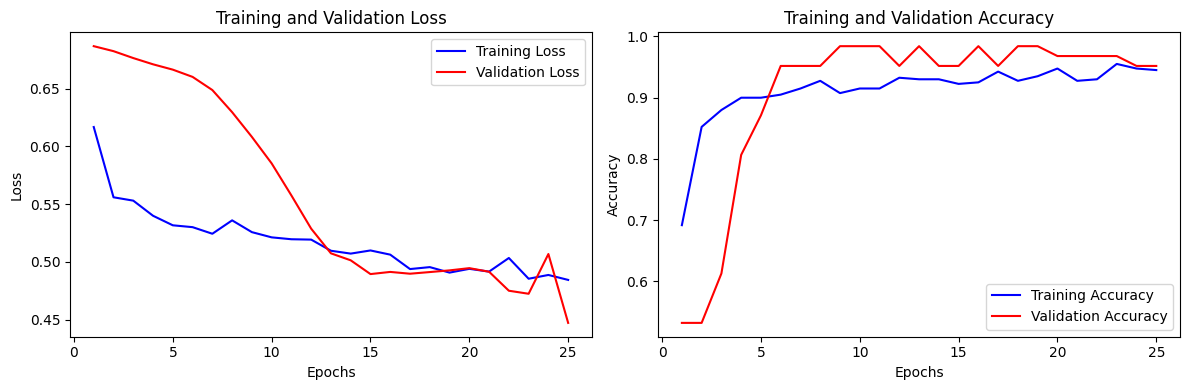

In [47]:
# Xavier initialization 
for param in model.parameters():
    if len(param.shape) > 1:
        torch.nn.init.xavier_normal_(param)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_loss, train_acc, val_loss, val_acc = train_and_validate(model, train_data_loader, eval_data_loader, criterion, optimizer, num_epochs=25)

epochs = range(1, len(train_loss) + 1)

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Step 4: Test Model and Plot Performance Metric

Test Accuracy: 94.14%
[0.08982416987419128, 0.06474391371011734, 0.093551404774189, 0.8395329117774963, 0.22738036513328552, 0.8162658214569092, 0.7020184993743896, 0.11987864971160889, 0.09615068882703781, 0.8444869518280029, 0.18066424131393433, 0.7848955988883972, 0.05732923746109009, 0.8769042491912842, 0.21049484610557556, 0.6242460608482361, 0.1299344301223755, 0.09934279322624207, 0.09738229960203171, 0.2904694080352783, 0.09932820498943329, 0.4107570946216583, 0.08677779883146286, 0.8262046575546265, 0.13821832835674286, 0.7691603899002075, 0.8489798903465271, 0.7368212938308716, 0.8417219519615173, 0.8129729628562927, 0.15621480345726013, 0.7479735016822815, 0.7592966556549072, 0.865933358669281, 0.4964344799518585, 0.6587910652160645, 0.7917438745498657, 0.8439210057258606, 0.5718814134597778, 0.32385149598121643, 0.2305893450975418, 0.15132315456867218, 0.1851315051317215, 0.08257526904344559, 0.853959321975708, 0.8274123072624207, 0.7624562978744507, 0.16474689543247223, 0.

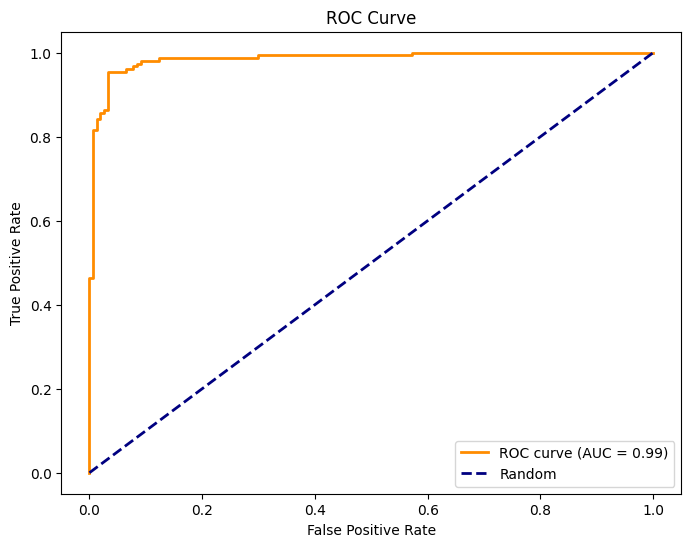

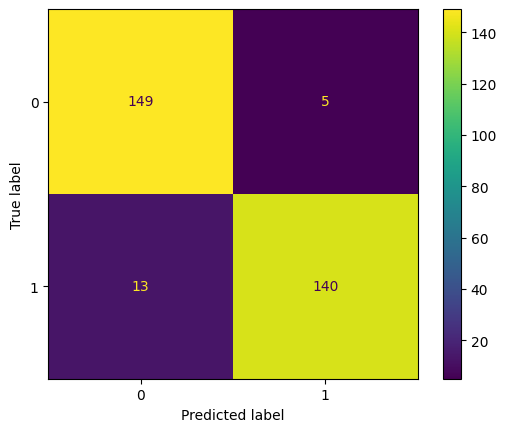

In [48]:
# Test the model
y_test, y_pred, y_probs = test(model, test_data_loader)

print(y_probs)

# Evaluate the performance
conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:")
print(conf_mat)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='viridis')

In [50]:
# Predicted label of every class 

output = {'true label': Y_test.squeeze(),
          'predicted_label': y_pred}

classification = pd.DataFrame(output)

# print(classification)